In [71]:
from __future__ import print_function
import pandas as pd
import numpy as np
import graphviz 
import sys
import time 
import inspect
import itertools
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import seaborn as sb
import re

from collections import defaultdict
import sklearn
from sklearn import tree
from sklearn.tree._tree import TREE_LEAF
from sklearn.tree import _criterion as criterions
from sklearn.utils import check_random_state
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

In [72]:
# import pyximport # pyximport.install()

In [73]:
####UNCOMMENT THIS FOR FIRST INSTALLATION OF THE UPDATED SKLEARN MODULES
#!python setup.py build_ext –inplace

In [74]:
%load_ext autoreload
%autoreload 2
from new_splitter import NewBestSplitter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
###show versions 
print('python', sys.version_info) #### #python sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
print('pandas', pd.__version__)#pandas 1.0.1
print('numpy', np.__version__)#numpy 1.18.1
print('sklearn', sklearn.__version__)#sklearn 0.22.1

python sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)
pandas 1.0.1
numpy 1.18.1
sklearn 0.22.1


In [76]:
t1 = time.time()
seednumber=0
drug_list=["para-aminosalicylic_acid","cycloserine","ethionamide","isoniazid","rifampicin","ethambutol","simulation_study"]
drug=drug_list[-1]
verbose=0
n_jobs_input=5

dummy_data=1
subset_cols=1  ###adds sim to file_outputs
number_of_cols_to_subset=100
usecollist=list(np.arange(0,number_of_cols_to_subset,1))

rule_or_or=0
cross_validate=1
test_size_percentage=0.2
train_on_full_dataset=1
use_roc_score=1
scoring_metric="roc_auc" #for cross_validation 
max_difference=1 
max_difference_for_heatmap=1

max_depth_crossval=15
max_depth_cross_val_list=np.arange(2,max_depth_crossval+1,1)
number_cross_val_splits=5
fixed_max_depth=max_depth_crossval

df_storage_SNP_imp=pd.DataFrame(columns=["SNP","importance"]) ###initalizing of empty dataframe 

if drug=="simulation_study":
    #genomic_file2="rif.2021_03_16.genotyped.filtered.tmat.bin.gz"
    #genomic_file2="rif.2021_03_16.genotyped.filtered.multisplit.ann.ns.tmat.bin"
    prior_list=["GeneA"]
    gene_list=prior_list
    gene_table_list=["GeneA"]
    fixed_max_depth=5
    list_of_studies=["Study1","Study2","Study3","Study4","Study5"]
    drug_short="Dummy"
    drug_short_title="Dummy"
    drug_short_sim_title="Dummy_sim"  
    #tb_profiler_drug_calls="tbp_drugcalls_rifinhemb.xlsx"
else:
    pass

perf_dict={}

if subset_cols==0:
    drug_title=drug_short_title
else:
    drug_title=drug_short_sim_title

In [77]:
###split2
#####functions to create new enhanced datasetes
def imputation_with_zero_func(df):
    df.replace({"N": 0},inplace=True)
    df.replace({"1/1": 0},inplace=True)
    df.replace({"2/2": 0},inplace=True)
    df.replace({"3/3": 0},inplace=True)
    return(df)

def create_total_mutation_count_per_gene_known_cat(df,renamed_columns,append_to_df=0):
    df.columns=renamed_columns
    dg=df.groupby(df.columns, axis=1).sum()
    if append_to_df==0:                     ###########DELETE LATER
        dg.columns=dg.columns+"_tot"
        out_df=dg
    else:
        dg.columns=dg.columns+"_tot"
        out_df=pd.concat([df, dg], axis=1, join_axes=[df.index])
    return out_df

def append_counts_to_df(df,gene_known_columns,gene_unique_columns): ###not used in this version
    df_totals=create_total_mutation_count_per_gene_known_cat(df,gene_known_columns,append_to_df=0)
    df.columns=gene_unique_columns
    out_df=pd.concat([df, df_totals], axis=1, join_axes=[df.index])
    return out_df

def change_index_to_column(dm,colname):  ###not used in this version
    dm[colname] = dm.index
    cols = list(dm)
    cols.insert(0, cols.pop(cols.index(colname))) ###move the prevous index column to the first column
    dm = dm.loc[:, cols]
    dm.reset_index(drop=True, inplace=True) ###remove index column
    dm.columns.name = None ###remove index column name
    return(dm)

class NewDecisionTreeClassifier(tree.DecisionTreeClassifier):
    
    def prune_tree(self):
        for i in range(self.tree_.capacity):
            cnt_1, cnt_0 = self.tree_.value[i][0]
            if cnt_0 > cnt_1:
                # this is negative node => don't split it further
                self.tree_.children_left[i] = TREE_LEAF
                self.tree_.children_right[i] = TREE_LEAF
        return self.tree_
    
    
    def get_max_features(self, n_features_):
        if isinstance(self.max_features, str):
            if self.max_features == "auto":
                if is_classification:
                    max_features = max(1, int(np.sqrt(n_features_)))
                else:
                    max_features = n_features_
            elif self.max_features == "sqrt":
                max_features = max(1, int(np.sqrt(n_features_)))
            elif self.max_features == "log2":
                max_features = max(1, int(np.log2(n_features_)))
            else:
                raise ValueError(
                    'Invalid value for max_features. Allowed string '
                    'values are "auto", "sqrt" or "log2".')
        elif self.max_features is None:
            max_features = n_features_
        elif isinstance(self.max_features, (numbers.Integral, np.integer)):
            max_features = self.max_features
        else:  # float
            if self.max_features > 0.0:
                max_features = max(1,
                                   int(self.max_features * n_features_))
            else:
                max_features = 0
        return max_features
    
    def get_min_weight_leaf(self, sample_weight, n_samples):
        if sample_weight is None:
            min_weight_leaf = (self.min_weight_fraction_leaf *
                               n_samples)
        else:
            min_weight_leaf = (self.min_weight_fraction_leaf *
                               np.sum(sample_weight)) 
        return min_weight_leaf
    
    def fit(self, X, y, sample_weight=None, check_input=True,
            X_idx_sorted=None, prune_tree=True):
        if self.splitter == 'new_best':
            n_samples, n_features_ = X.shape
            crit = criterions.Gini(1, np.array([2]))
            self.splitter = NewBestSplitter(crit, #crit,
                                   self.get_max_features(n_features_),
                                   self.min_samples_leaf,
                                   self.get_min_weight_leaf(sample_weight, n_samples),
                                   check_random_state(self.random_state)
                                  )
        super(NewDecisionTreeClassifier, self).fit(
            X, y,
            sample_weight=sample_weight,
            check_input=check_input,
            X_idx_sorted=X_idx_sorted)
        
        if prune_tree:
            self.prune_tree()
        return self
    
    def get_stats(self, feature_names=None):
        def _name(idx):
            if feature_names is None:
                return idx
            else:
                return feature_names[idx
                                    ]
        if isinstance(self.splitter, NewBestSplitter):
            result = []
            ties = self.splitter.get_current_node_ties()
            for i in range(self.splitter.get_node_idx() + 1):
                result.append([_name(idx) for idx in np.flatnonzero(ties[i])])
            return result
        else:
            raise ValueError('this action is supported for NewBestSplitter only')

(LEAF_SENSITIVE, LEAF_RESISTANT, 
 NODE_REGULAR, 
 NODE_AND_UPPER, NODE_AND_LOWER, 
 NODE_REVERSE_UPPER, NODE_REVERSE_LOWER) = ['_leaf_sens_', '_leaf_res_', 
                                           '_reg_', 
                                           '_and_up_', '_and_low_',
                                           '_rev_up_', '_rev_low']
           


def is_left_child(tree):
    """
    True - node is left child (i.e. it's close to "zero" class)
    False - node is right child (i.e. it's close to "one" class)
    """
    return ([True] # root of the tree is assumed to be left child
            + [node_idx in tree.children_left
               for node_idx in range(1, tree.capacity)]
           )
           
def get_feature_types(feature_names, stats, is_left_nodes):
    result = {f: FeatureType.NotUsed for f in feature_names}
    all_ties = []
    
    def _pure_tie(tie):
        for feature in tie:
            if result[feature] != FeatureType.AndTie:
                result[feature] = FeatureType.PureTie
                
    def _regular(feature):
        result[feature] = FeatureType.Regular
        
    def _and_tie(feature):
        was_in_tie = False
        for tie in all_ties:
            if feature in tie:
                was_in_tie = True
                for anoth_feature in tie:
                    result[anoth_feature] = FeatureType.AndTie
        if not was_in_tie:
            _regular(feature)
    
    for node_ties, is_left in zip(stats, is_left_nodes):
        if len(node_ties) > 1:
            all_ties.append(node_ties)
            _pure_tie(node_ties)
        elif len(node_ties) == 1:
            feature = node_ties[0]
            if is_left:
                _regular(feature)
            else:
                # node turned right
                _and_tie(feature)
    return result
           
def filter_stats(stats, feature_types, desired_feature_type):
    return [[feature for feature in node_stats
             if feature_types[feature] == desired_feature_type] 
            for node_stats in stats]

from enum import Enum
class FeatureType(Enum):
    NotUsed = 0
    Regular = 1
    PureTie = 2
    AndTie = 3
    
def get_feature_importance_from_random_forest(X,y,df_x,save_file=1): ###not used in this version
    from sklearn.ensemble import RandomForestClassifier
    rnd_clf = RandomForestClassifier(n_estimators=100, max_features=None,n_jobs=n_jobs_input, random_state=None)
    rnd_clf.fit(X, y)
    df_out=pd.DataFrame(zip(df_x.columns, rnd_clf.feature_importances_))
    df_out.columns=["SNP","importance"]
    df_out["SNP"]=df_out["SNP"].str.split("_",expand=True)
    if verbose==1:
        print(df_out.shape,"shape before")
    df_out=df_out[df_out["importance"]>0]  ###importance greater than 0
    if verbose==1:
        print(df_out.shape,"shape after")
    dg=df_out.groupby("SNP").count()
    if verbose==1:
        print(dg.shape,"shape before")
    dg=dg[dg["importance"]>1] #####used more than 1 
    if verbose==1:
        print(dg.shape,"shape after")
    dz=dg.sort_values("importance",ascending=False)
    if save_file==1:
        dz.to_csv(title)
    return(dz)

def show_allele_freq_table(df):
    y=np.bincount(np.sum(df.values,axis=1))
    ii = np.nonzero(y)[0]
    print(np.vstack((ii,y[ii])).T)

def create_bargraph_from_store_dict(store_dict,save=0):
    keys = ['_'.join(i) for i in store_dict.keys()]
    keys, values = zip(*sorted(zip(keys, store_dict.values())))
    if save==1:
        plt.savefig("barchart_stepdown.png")
    plt.bar(keys, values)

def get_sort_order_to_have_prior_columns_first(prior_list,df):
    store_array=np.zeros(df.shape[1])
    prior_list=["unique_id"]+prior_list
    i=-50
    for gene in prior_list:
        store_array=store_array+df.columns.str.contains(gene)*i
        i=i+1
    if verbose==1:
        print(store_array)
    return(store_array)    

def generate_new_combinations_stepping_down(list_values):
    return(list(itertools.combinations(list_values,len(list_values)-1)))

def scoring_function(test):
    return(np.sum([dict_values[x] for x in test]))

def generate_new_combinations_stepping_up(combinations,list_values):
    return([list(combinations[0])+list(x) for x in list_values if x not in list(combinations[0])])

def score_all_entries(combinations,scoring_function):
    return(zip(combinations,map(scoring_function,combinations))) ###change 

def get_highest_entry_index(scored_list):
    return(np.argmax([x[1] for x in scored_list]))

def get_key_with_max_value(values_dict):
    return(max(values_dict, key=values_dict.get))
  
def create_dict_score_by_size_studygroup(scores_across_all_combinations_dict):
    score_lists_for_combi_number = defaultdict(list)
    for i in list(set([len(x) for x in scores_across_all_combinations_dict.keys()])):
        [score_lists_for_combi_number[len(x)].append(scores_across_all_combinations_dict[x]) for x in scores_across_all_combinations_dict.keys() if len(x)==i]
    return(score_lists_for_combi_number)

def get_sort_order_to_have_prior_columns_first(prior_list,df):
    store_array=np.zeros(df.shape[1])
    prior_list=["unique_id"]+prior_list
    i=-50
    for gene in prior_list:
        store_array=store_array+df.columns.str.contains(gene)*i
        i=i+1
    if verbose==1:
        print(store_array)
    return(store_array)  

def resort_dataframe_based_on_priors(prior_list,df_x):
    sort_order=get_sort_order_to_have_prior_columns_first(prior_list,df_x)    
    new_column_order=[x for _,x in sorted(zip(sort_order,df_x.columns),reverse=False)]
    df_x=df_x[new_column_order]
    X=df_x.values  
    return(df_x, X)

def run_cross_validation(model,param_grid,number_cross_val_splits,scoring_metric,verbose=1):
    kfold = StratifiedKFold(n_splits=number_cross_val_splits, shuffle=True, random_state=seednumber)
    grid_search = GridSearchCV(model, param_grid, scoring=scoring_metric, cv=kfold, verbose=1,refit="accuracy",n_jobs=n_jobs_input)#,refit=False) n_jobs=-1,
    grid_result = grid_search.fit(X, y)
    results=grid_result.cv_results_
    if verbose==1:
        print(grid_result.best_params_) 
        print({k: v for k, v in results.items() if k.startswith(('mean_test','std_test'))})
    return(grid_result)

def split_dataset_train_test(X, y, test_size_percentage,verbose,seednumber):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seednumber, test_size=test_size_percentage,stratify=y) ###stratify on y
    if verbose==1:
        print(np.sum(y_test),"number of values in y_test")
        print(np.sum(y),"number of values in entire dataset")
    return(X_train, X_test, y_train, y_test)

def get_node_types(clf):
    def is_leaf(i):
        return ((clf.tree_.children_left[i] == TREE_LEAF)
                and (clf.tree_.children_right[i] == TREE_LEAF))
    def is_sens(i):
        cnt_1, cnt_0 = clf.tree_.value[i][0]
        return cnt_0 <= cnt_1
    def is_res(i):
        cnt_1, cnt_0 = clf.tree_.value[i][0]
        return cnt_0 > cnt_1
    
    def is_and(i):
        r_child = clf.tree_.children_right[i]
        if is_leaf(r_child):
            return False
        r_grandchild = clf.tree_.children_right[r_child]
        if is_leaf(r_grandchild) and is_res(r_grandchild):
            return True
        return False
    
    def is_revers(i):
        r_child = clf.tree_.children_right[i]
        if is_leaf(r_child):
            return False
        r_grandchild = clf.tree_.children_right[r_child]
        if is_leaf(r_grandchild) and is_sens(r_grandchild):
            return True
        return False
    
    result = {}
    for i in range(clf.tree_.capacity):
        if i in result:
            continue
        if is_leaf(i):
            # it's leaf
            result[i] = LEAF_RESISTANT if is_res(i) else LEAF_SENSITIVE
        else:
            # it's node
            result[i] = NODE_REGULAR
            if is_and(i):
                result[i] = NODE_AND_UPPER
                result[clf.tree_.children_right[i]] = NODE_AND_LOWER
            if is_revers(i):
                result[i] = NODE_REVERSE_UPPER
                result[clf.tree_.children_right[i]] = NODE_REVERSE_LOWER
            
    return result

def add_node_type_to_dot_data(node2type_dict, dot_data):
    res = dot_data[:]
    for node_id, node_type in node2type_dict.items():
        res = res.replace(f'\n{node_id} [label=<',
                                    f'\n{node_id} [label=<{node_type}<br/>')
    return res

###Plotting funcgtions 
def plot_tree_per_study(clf, feature_names, show_node_types=True, show_id=False,study="tbd",title_graph="undefined"):
    dot_data = tree.export_graphviz(clf, 
                                feature_names=feature_names,
                                    class_names=["sensitive", "resistant"],
                                    node_ids=show_id,
                                out_file=None,
                                filled=True, 
                                rounded=True, 
                                special_characters=True) 
    if show_node_types:
        if 'node2type' in dir(clf):
            node2type_dict = clf.node2type
        else:
            node2type_dict = get_node_types(clf)
        dot_data = add_node_type_to_dot_data(node2type_dict, dot_data)
    graph = graphviz.Source(dot_data)  
    graph.render(title_graph);
    return graphviz.Source(dot_data)

def plot_tree(clf, feature_names, show_node_types=True, show_id=False,title_graph="undefined"):
    dot_data = tree.export_graphviz(clf, 
                                feature_names=feature_names,
                                    class_names=["sensitive", "resistant"],
                                    node_ids=show_id,
                                out_file=None,
                                filled=True, 
                                rounded=True, 
                                special_characters=True) 
    if show_node_types:
        if 'node2type' in dir(clf):
            node2type_dict = clf.node2type
        else:
            node2type_dict = get_node_types(clf)
        dot_data = add_node_type_to_dot_data(node2type_dict, dot_data)
        
    graph = graphviz.Source(dot_data)  
    graph.render(title_graph);
    return graphviz.Source(dot_data)

def plot_tree_backwards_stepping(clf,columns_of_df,study,title_graph="undefined"):
    dot_data = tree.export_graphviz(clf, out_file=None, class_names=["sensitive", "resistant"], feature_names=columns_of_df,filled=True, rounded=True, special_characters=True)  
    graph = graphviz.Source(dot_data)  
    graph.render(title_graph);
    return(graph) 

def split_string_authoryearcountry(string):
    dict_trans={"pe":"Peru","kr":"Korea","cn":"China","pt":"Portugal","ru":"Russia","uz":"Uzbekistan","za":"Zambia","by":"Belarus","tn":"Tunisia","pk":"Pakistan","mw":"Malawi","NA":"NA","th":"Thailand","ph":"Philipines","gb":"Great_Britain"}
    string_authoryear=string.split("_")[0]
    match = re.match(r"([a-z]+)([0-9]+)", string_authoryear, re.I)
    if match:
        items = match.groups()
        string_author=items[0].capitalize()
        string_year=items[1]
        string_country_short=string.split("_")[1]
        string_country_long=dict_trans[string_country_short]
        return(string_author+" ("+string_year+", "+string_country_long+")")

def plot_scatter_points_by_size_studygroup(scores_across_all_combinations_dict,score_lists_for_combi_number,title_graph):
    store_max=[]
    x_coords=[]
    x = np.array(list(set([len(x) for x in scores_across_all_combinations_dict.keys()])))
    for i in list(set([len(x) for x in scores_across_all_combinations_dict.keys()])):
        x_array=np.repeat(i,len(score_lists_for_combi_number[i]))
        plt.plot(x_array, score_lists_for_combi_number[i], '.')
        store_max.append(max(score_lists_for_combi_number[i]))
        x_coords.append(i)
    plt.plot(np.array(x_coords), np.array(store_max), '-',color="grey")
    for value,xy in enumerate(zip(np.array(x_coords)+0.05, np.array(store_max)+0.5)):                                       # <--
        plt.annotate('%s' % store_max[value], xy=xy, textcoords='data')
    plt.xlabel("Size of subset")
    plt.ylabel("Performance")
    plt.savefig(title_graph)
    plt.show()

def plot_crossval(max_depth,scores,title_graph,yerr):
    plt.plot(max_depth, scores)
    plt.legend()
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    title=title_graph
    plt.title(title)
    axes = plt.gca()
    lowerb=np.round(np.min(scores)*0.8,1)
    axes.set_ylim([lowerb,1])
    plt.errorbar(max_depth, scores, yerr=yerr)
    plt.savefig(title)

def plot_and_build_heatmap(drug_title,inputfile,remove_importance_label=1,sort_on_snp_loc=1,titlesave=None,subset_list=None):
    df=pd.read_csv(inputfile).iloc[:,:]
    df.drop("feature_genes",axis=1,inplace=True)
    df.index=[x.rsplit('_', 1)[0]+" ("+x.rsplit('_', 1)[1]+")" for x in df["SNP"]]
    ###resort
    if sort_on_snp_loc==1:
        df["sort"]=[x.rsplit('_', 1)[1] for x in df["SNP"]]
        df["sort"]=df["sort"].astype(float)
        df.sort_values('sort',inplace=True,ascending=True)
        df.drop(columns=["sort"], inplace=True)
    ###arrange columns    
    if remove_importance_label==1:
        df.columns=[x[11:] for x in df.columns]
    try:
        new_cols=[split_string_authoryearcountry(x) for x in df.columns]
    except:
        new_cols=df.columns

    df=df.iloc[:,3:]
    df.columns=new_cols[3:]
    print(new_cols[3:],"columns check")
    
    for i in subset_list:
        df[df.index.str.contains(i)]=df[df.index.str.contains(i)]+40
    
    if drug_title=="ETN":
        fig, ax = plt.subplots(figsize=(10, 20))
    else:
        fig, ax = plt.subplots(figsize=(11, 9))

    sb.heatmap(df, cmap="Greens", linewidth=0.3, cbar_kws={"shrink": .8},xticklabels=True, yticklabels=True,cbar=False)

    # title
    title = 'Feature Inclusion\n'.upper()
    plt.title(title, loc='left')
    plt.savefig(titlesave)
    plt.show()

weights = {0:1.0, 1:1.0}

class ShortListDecisionTreeClassifier(NewDecisionTreeClassifier):
    
    def __init__(self, *args, **kwargs):
        self.feature_genes = kwargs.pop('feature_genes')
        self.short_list = kwargs.pop('short_list')
        self.max_difference = kwargs.pop('max_difference')
        super().__init__(*args, **kwargs)
    
    def prune_tree_short_list(self):
        tree_ = self.tree_
        short_list = set(self.short_list)
        updated_list = short_list.copy()
        self.node2type = get_node_types(self)
        
        visited = set()
        queue = []  # queue

        def can_add_gene(current_gene):
            difference = (updated_list.union([current_gene])) - short_list
            return len(difference) <= self.max_difference
        
        def make_leaf(i):
            tree_.children_left[i] = TREE_LEAF
            tree_.children_right[i] = TREE_LEAF
            
        def enqueue_children(i):
            for next_node in [tree_.children_left[i],  # go to left child first
                              tree_.children_right[i]  # go to right child then
                             ]:
                if not next_node in visited:
                    queue.append(next_node)
        
        def process_node(i):
            if i in visited:  
                return
            visited.add(i) 
        
            node_type = self.node2type[i]
            if node_type in [LEAF_RESISTANT, LEAF_SENSITIVE]:
                return
            cnt_1, cnt_0 = tree_.value[i][0]
            if cnt_0 > cnt_1:
                # this is negative node => don't split it further
                make_leaf(i)
                return
            else:
                current_feature = tree_.feature[i]
                current_gene = self.feature_genes[current_feature]
                can_add = can_add_gene(current_gene)
    #             print(f'{features_names[current_feature]} updated_list = {updated_list} can_add = {can_add}')
                if not can_add:
                    if node_type == NODE_AND_LOWER:  # dont prune and_low nodes
                        # we do no count and_low's gene as a new added gene
                        enqueue_children(i) 
                    else:
                        make_leaf(i)
                        return
                else:
                    if node_type == NODE_AND_LOWER:
                        # we do no count and_low's gene as a new added gene
                        enqueue_children(i)
                    else:
                        updated_list.update([current_gene]) # take this gene into account
                        enqueue_children(i)
            
            while queue:
                process_node(queue.pop(0))
        
        process_node(0)  # start with top node          
        return tree_
    
    def fit(self, X, y, sample_weight=None, check_input=True,
            X_idx_sorted=None):
        super().fit(
            X, y,
            sample_weight=sample_weight,
            check_input=check_input,
            X_idx_sorted=X_idx_sorted,
            prune_tree=False)
        
        self.prune_tree_short_list()
        return self

def feature_mapper(feature_name):
    return feature_name.rsplit('_',1)[0]

def print_html_cv_table(title_graph,results):
    pd.DataFrame({k: v for k, v in results.items() if k.startswith(('mean_test','std_test'))}).to_html(title_graph)

def summarize_crossval_accuracy(grid_result):
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    print(means,"means")
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    scores = np.array(means)#.reshape(len(max_depth))
    return scores

def get_prior_list_and_max_diff(string,shortlist,max_difference):
    boolean_list=[x in shortlist for x in string]
    out2=[i for i, n in enumerate(boolean_list) if n == True]+[i for i, n in enumerate(boolean_list) if n == False][:max_difference]
    return(out2,np.array(string)[out2])

def get_metrics_predictions(cm):
    TP = cm[1][1]
    FP = cm[0][1]
    FN = cm[1][0]
    TN = cm[0][0]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = np.true_divide(TP,(TP+FN))
    # Specificity or true negative rate
    TNR = np.true_divide(TN,(TN+FP))
    # Precision or positive predictive value
    PPV = np.true_divide(TP,(TP+FP))
    # Negative predictive value
    NPV = np.true_divide(TN,(TN+FN))
    # Fall out or false positive rate
    FPR = np.true_divide(FP,(FP+TN))
    # False negative rate
    FNR = np.true_divide(FN,(TP+FN))
    # False discovery rate
    FDR = np.true_divide(FP,(TP+FP))
    ACC = np.true_divide(TP+TN,TP+FP+FN+TN)
    return(TPR,TNR,PPV,NPV,FPR,FNR,FDR,ACC)

def subset_study(dm,study_grouping,drug):
    dm_per_study=dm[dm["study_country_concat"].isin(study_grouping)] ###subset for given study 
    y=dm_per_study[drug]  ###select y_labels
    dm_per_study.drop([drug,"study_country_concat"],inplace=True,axis=1) ###remove drug and study column
    columns_of_df=dm_per_study.columns
    X=dm_per_study.values ###select X values 
    return y,X,columns_of_df

def get_feature_importance_from_tree(clf,columns_of_df,study,df_storage_SNP_imp,verbose=0,max_difference=3):
    dg=pd.DataFrame(zip([columns_of_df[x] for x in clf.tree_.feature],clf.tree_.feature,[clf.feature_importances_[x] for x in clf.tree_.feature]))
    importance_column="importance"+"_"+str(study)
    #importance_column=str(study)
    dg.columns=["SNP","feature",importance_column];dg=dg[["SNP",importance_column]];dg.sort_values([importance_column],ascending=True)
    if verbose==1:
        print(dg)
    dg=dg[dg[importance_column]>0]
    dg["feature_genes"]=[feature_mapper(f) for f in dg.SNP] ####get genes
    indexbool,shortlist_genes=get_prior_list_and_max_diff(dg["feature_genes"],prior_list,max_difference) ###subset only prior_list and max_difference genes
    print(indexbool,"indexbool")
    dg=dg.iloc[indexbool] ###save
    df_storage_SNP_imp=pd.merge(df_storage_SNP_imp,dg,on="SNP",how="outer")
    df_storage_SNP_imp.drop("feature_genes",axis=1,inplace=True)
    return(df_storage_SNP_imp)

def extract_gene_from_columnname(dm):
    features_names = list(dm.columns[0: dm.shape[1]]) 
    features_names.remove(drug)
    features_names.remove('study_country_concat')
    feature_genes = [feature_mapper(f) for f in features_names]
    return features_names,feature_genes

def lookup_grade_bef(score):
    #print(type(score),"score type")
    #print(score,"score")
    score=int(score)
    match = (df_gff['Start'] <= score) & (df_gff['End'] > score)
    #print(match,"match")
    grade = df_gff['Gene'][match]
    if np.sum(grade.values)==0:
        match = df_gff['End'] > score
        if(np.sum(match))==0:
            grade=pd.Series([score])
        else:
            grade = df_gff['Gene'][match]+"_bef"
    return grade.values[0]

#####functions to create new enhanced datasetes
def col_from_snp_to_gene_simple(snp_series):
    genes_series=list(map(str, pd.Series(snp_series).apply(lookup_grade_bef).tolist())) ###using the bef adjustment
    return(genes_series)

def create_pos_and_gene_df(df_x, number_of_columns_to_remove_at_end):
    df_pos_info=pd.DataFrame(df_x.columns[:-number_of_columns_to_remove_at_end].astype(float));df_pos_info.columns=["positions"]
    df_pos_info["gene"]=0;df_pos_info["snp_counter"]=0;df_pos_info["unique_id"]=0; df_pos_info["gene_known"]=0
    df_pos_info["gene"]=col_from_snp_to_gene_simple(df_pos_info["positions"])
    df_pos_info["positions"]=df_pos_info["positions"].astype(str)
    df_pos_info["unique_id"]=df_pos_info["gene"]+"_"+df_pos_info["positions"] 
    genes_and_pos_columns=list(df_pos_info["unique_id"])
    columns_to_add_to_end=list(df_x.columns[-2:])
    if verbose==1:
        print(columns_to_add_to_end,"columns_to_add_to_end")
    renamed_columns=genes_and_pos_columns+columns_to_add_to_end
    return renamed_columns,df_pos_info

def prepare_dataset(df_dst,df_genomic,study_grouping):
    df_genomic2=df_genomic.copy()
    df_dst_subset=df_dst[df_dst["study_country_concat"].isin(study_grouping)] ###subset df_subset
    df_genomic2.set_index('run_accession', inplace=True)
    df_dst_subset.set_index('wgs_id', inplace=True)
    ###merge to align dst file with genomic file
    df_merge=pd.merge(df_genomic2,df_dst_subset,left_index=True,right_index=True,how="left") ###merge the genomic database and the study file on accession number ###index based merging saves a lot of time
    df_merge.dropna(subset=[drug],inplace=True) ###drop NA values
    #####sort the dataframe based on prior list 
    renamed_columns,df_merge_pos_info=create_pos_and_gene_df(df_merge,2); df_merge.columns=renamed_columns
    sort_order=get_sort_order_to_have_prior_columns_first(prior_list,df_merge)    
    new_column_order=[x for _,x in sorted(zip(sort_order,df_merge.columns),reverse=False)]
    df_merge=df_merge[new_column_order]
    return(df_merge)

def accuracy_and_cm(X_test,y_test,selection_model):
    y_pred = selection_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print()
    print(cm); print()
    TPR,TNR,PPV,NPV,FPR,FNR,FDR,ACC = accuracy_metrics(cm)
    print("TPR = %0.2f, TNR = %0.2f, ACC = %0.2f" % (TPR*100,TNR*100,ACC*100))
    return(ACC,TPR,TNR,y_pred,PPV,NPV)  

def fit_model(clf,X_input,y_input,show_accuracy=1):
    clf = clf.fit(X, y)
    if show_accuracy==1:
        accuracy_score=clf.score(X, y, sample_weight=None)
    print(accuracy_score,"accuracy score on training data")
    return(clf)

def make_predictions(clf,X_to_test,y_to_compare):
    predictions_prob = clf.predict_proba(X_to_test)
    predictions_binary = clf.predict(X_to_test)
    cm=confusion_matrix(y, predictions_binary)
    return(predictions_prob,predictions_binary,cm)

def get_roc_score(y, predictions):
    try:
        print(roc_auc_score(y, predictions[:,1]),"roc auc score")
        roc_score=roc_auc_score(y, predictions[:,1])
    except:
        print("failure_to_calculate_ROC")
        roc_score=0
    return(roc_score)

def cross_validation_regular_tree(number_cross_val_splits,plotting,verbose,scoring_metric,max_depth_cross_val_list):
    param_grid = dict(max_depth=max_depth_cross_val_list)
    model = tree.DecisionTreeClassifier(criterion="gini",min_samples_leaf=2,random_state=seednumber) ###remove jobs=-1
    grid_result=run_cross_validation(model,param_grid,number_cross_val_splits,scoring_metric,verbose=1)
    max_depth_setting=grid_result.best_params_["max_depth"] ###re-use the cross_valudated optimal value

    if verbose==1:
        print(max_depth_setting)
        print(grid_result.best_params_)

    scores=summarize_crossval_accuracy(grid_result)

    ###plotting
    title_graph=drug_title+"_crossval_regtree"+"_cv"
    plot_crossval(max_depth_cross_val_list,scores,title_graph,grid_result.cv_results_['std_test_score'])
    return(max_depth_setting)
    

def add_str_cols(df, prefix='abc', num_cols=2):
    new_cols = [f'{prefix}.{n}' for n in range(num_cols)]
    values = np.random.choice([0, 1], size=[len(df), num_cols])
    df[new_cols] = values
    return df

def get_column_groups(columns):
    res = {}
    for col in columns:
        if '.' in str(col):
            parts = str(col).split('.')
            assert len(parts) == 2, f"wrong column name (too many dots): {col}"
            first, last = parts
            if first in res:
                res[first] = res[first] + [col]
            else:
                res[first] = [col]
    return res

def aggregate_groups(df, column_groups, new_col_suffix='.9'):
    for group, cols in column_groups.items():
        df[f'{group}{new_col_suffix}'] = df[cols].any(axis=1).astype(int)
    return df

In [78]:
if dummy_data==1:
    df=pd.read_csv("wgs_dummydata_v3.csv")

In [79]:
df.head()

,run_accession,1,11,21,31,41,51,61,71,81,...,891,901,911,921,931,941,951,961,971,981
0,ERR1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ERR2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ERR3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ERR4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ERR5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
### study selectios
df_studies=pd.read_csv("study_dummydata.csv")
df_studies_adj=df_studies[["wgs_id","study_country_concat",drug]]

##### load genetable
df_gff = pd.read_csv("gff_dummydata.csv",sep=',')  ###this is a gff

In [81]:
####prepare the entire dataset (e.g. before subsetting on a specific study
dm=prepare_dataset(df_studies_adj,df,list_of_studies)

In [82]:
features_names,feature_genes=extract_gene_from_columnname(dm)
if verbose==1:
    print(feature_genes[0:50],"genes of first 50 SNPs")

In [83]:
SNP_table_dict={}
for i in gene_table_list: 
    print(i)
    df_check_variants=dm.filter(regex=i)
    df_check_variants=df_check_variants.astype(int)
    SNP_table_dict[i]=sum(df_check_variants.sum(axis=0)>0)

df_snp_table=pd.DataFrame.from_dict(SNP_table_dict, orient='index')
df_snp_table.columns=["SNP"]
title=drug_short+"_snp_table.csv"
df_snp_table.to_csv(title)
df_snp_table

GeneA


,SNP
GeneA,15


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  70 out of  70 | elapsed:    0.1s finished
No handles with labels found to put in legend.


Fitting 5 folds for each of 14 candidates, totalling 70 fits
{'max_depth': 4}
{'mean_test_score': array([0.50378931, 0.50567467, 0.50940089, 0.48144042, 0.48190763,
       0.48284204, 0.48358097, 0.48514867, 0.48076413, 0.48236341,
       0.48236341, 0.48310234, 0.47948349, 0.47123551]), 'std_test_score': array([0.00855329, 0.00811678, 0.00837889, 0.04327531, 0.04247836,
       0.04090191, 0.04105403, 0.04122576, 0.03883951, 0.0382187 ,
       0.0382187 , 0.03849724, 0.04880442, 0.04614639])}
4
{'max_depth': 4}
Best: 0.509401 using {'max_depth': 4}
[0.50378931 0.50567467 0.50940089 0.48144042 0.48190763 0.48284204
 0.48358097 0.48514867 0.48076413 0.48236341 0.48236341 0.48310234
 0.47948349 0.47123551] means
0.503789 (0.008553) with: {'max_depth': 2}
0.505675 (0.008117) with: {'max_depth': 3}
0.509401 (0.008379) with: {'max_depth': 4}
0.481440 (0.043275) with: {'max_depth': 5}
0.481908 (0.042478) with: {'max_depth': 6}
0.482842 (0.040902) with: {'max_depth': 7}
0.483581 (0.041054) wit

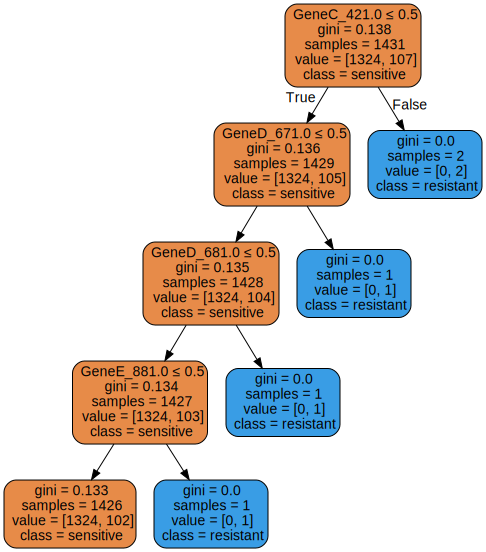

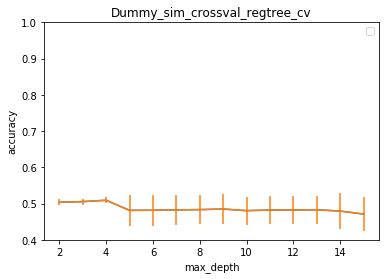

In [84]:

####fit regular tree on entire dataset
y,X,columns_of_df= subset_study(dm,list_of_studies,drug)
X_train, X_test, y_train, y_test=split_dataset_train_test(X, y, test_size_percentage,verbose=0,seednumber=seednumber)

if cross_validate==1:
    max_depth_setting=cross_validation_regular_tree(number_cross_val_splits,1,1,scoring_metric,max_depth_cross_val_list)
else:
    max_depth_setting=fixed_max_depth

###fit tree
clf = tree.DecisionTreeClassifier(max_depth=max_depth_setting,criterion="gini",splitter="best",min_samples_leaf=1,random_state=seednumber)

if train_on_full_dataset==1:
    clf=fit_model(clf,X_input=X,y_input=y,show_accuracy=1)
    predictions_prob,predictions_binary,cm=make_predictions(clf,X_to_test=X,y_to_compare=y) 
    TPR,TNR,PPV,NPV,FPR,FNR,FDR,ACC=get_metrics_predictions(cm)
    roc_score=get_roc_score(y, predictions_prob)
else:
    clf=fit_model(clf,X_input=X_train,y_input=y_train,show_accuracy=1)
    predictions_prob,predictions_binary,cm=make_predictions(clf,X_to_test=X_test,y_to_compare=y_test)
    TPR,TNR,PPV,NPV,FPR,FNR,FDR,ACC=get_metrics_predictions(cm)
    roc_score=get_roc_score(y_test, predictions_prob)

perf_dict["regtree_sens"]=TPR;perf_dict["regtree_spec"]=TNR;perf_dict["regtree_acc"]=ACC;perf_dict["regtree_AUC"]=roc_score

plot_tree(clf, features_names, show_node_types=False, show_id=False,title_graph=str(drug_title)+"_regular_tree_entire_dataset")  ###plot tree

0.9273235499650594 accuracy score on training data
0.514018691588785 roc auc score


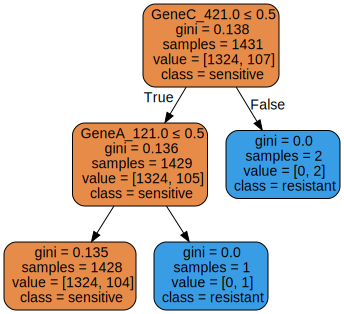

In [85]:

max_depth_setting=fixed_max_depth

clf = ShortListDecisionTreeClassifier(criterion="gini", splitter='new_best',class_weight=weights, min_samples_leaf=1, feature_genes=feature_genes,
                                      short_list=prior_list, max_difference=max_difference)

if train_on_full_dataset==1:
    clf=fit_model(clf,X_input=X,y_input=y,show_accuracy=1)
    predictions_prob,predictions_binary,cm=make_predictions(clf,X_to_test=X,y_to_compare=y)   
    TPR,TNR,PPV,NPV,FPR,FNR,FDR,ACC=get_metrics_predictions(cm)
    roc_score=get_roc_score(y, predictions_prob)
else:
    clf=fit_model(clf,X_input=X_train,y_input=y_train,show_accuracy=1)
    predictions_prob,predictions_binary,cm=make_predictions(clf,X_to_test=X_train,y_to_compare=y_test)
    TPR,TNR,PPV,NPV,FPR,FNR,FDR,ACC=get_metrics_predictions(cm)
    roc_score=get_roc_score(y_test, predictions_prob)

perf_dict["TBtree_sens"]=TPR;perf_dict["TBtree_spec"]=TNR;perf_dict["TBtree_acc"]=ACC;perf_dict["TBtree_AUC"]=roc_score

plot_tree(clf, features_names, show_node_types=False, show_id=False,title_graph=str(drug_title)+"Tbtree_entire_dataset") ###plot

Study1 study
0.96 accuracy score on training data
0.50625 roc auc score
            SNP  importance_Study1
0   GeneD_641.0           0.236366
1   GeneE_941.0           0.000000
2   GeneA_141.0           0.164788
3    GeneA_71.0           0.167534
4   GeneE_891.0           0.170350
5     GeneA_1.0           0.086253
6   GeneE_901.0           0.086984
7   GeneE_951.0           0.087724
8   GeneE_971.0           0.000000
9   GeneE_971.0           0.000000
10  GeneE_971.0           0.000000
11  GeneE_971.0           0.000000
12  GeneE_971.0           0.000000
13  GeneE_971.0           0.000000
14  GeneE_971.0           0.000000
15  GeneE_971.0           0.000000
16  GeneE_971.0           0.000000
[1, 2, 4, 0] indexbool
Study2 study
0.9217391304347826 accuracy score on training data
0.5588666065795403 roc auc score
            SNP  importance_Study2
0   GeneE_881.0           0.722596
1   GeneE_981.0           0.171198
2   GeneC_461.0           0.000000
3   GeneA_151.0           0.004507
4  

/opt/storage2/wouter/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/storage2/wouter/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:592: RuntimeWarning: invalid value encountered in true_divide
/opt/storage2/wouter/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:600: RuntimeWarning: invalid value encountered in true_divide
/opt/storage2/wouter/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/stora

Study5 study
0.7837837837837838 accuracy score on training data
0.5555555555555556 roc auc score
            SNP  importance_Study5
0   GeneC_421.0           0.481117
1   GeneD_711.0           0.000000
2   GeneE_931.0           0.257886
3   GeneE_981.0           0.127152
4   GeneE_891.0           0.041689
5   GeneB_251.0           0.021887
6   GeneB_351.0           0.022629
7   GeneD_621.0           0.023409
8   GeneD_731.0           0.024230
9   GeneE_971.0           0.000000
10  GeneE_971.0           0.000000
11  GeneE_971.0           0.000000
12  GeneE_971.0           0.000000
13  GeneE_971.0           0.000000
14  GeneE_971.0           0.000000
15  GeneE_971.0           0.000000
16  GeneE_971.0           0.000000
17  GeneE_971.0           0.000000
18  GeneE_971.0           0.000000
[0] indexbool
Index(['Study1', 'Study2', 'Study3', 'Study4', 'Study5'], dtype='object') columns check


/opt/storage2/wouter/anaconda2/envs/py3/lib/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


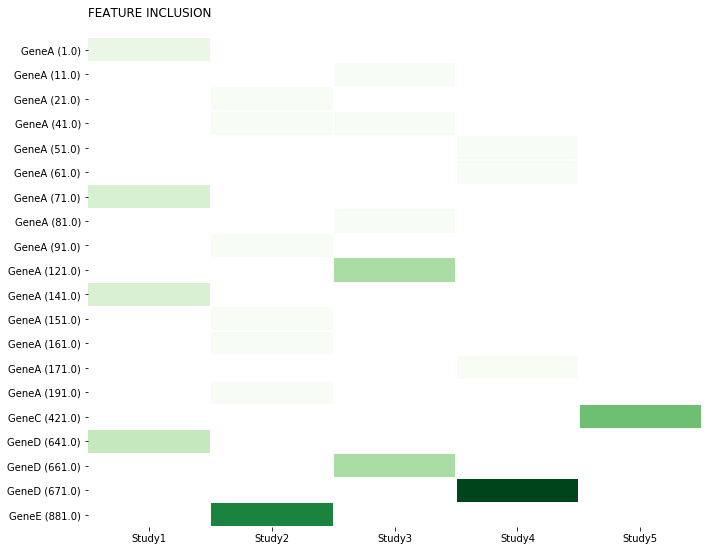

1.4193952083587646


/opt/storage2/wouter/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,importance,SNP,importance_Study1,importance_Study2,importance_Study3,importance_Study4,importance_Study5,feature_genes
0,NaN,GeneA_141.0,0.164788,NaN,NaN,NaN,NaN,GeneA
1,NaN,GeneA_71.0,0.167534,NaN,NaN,NaN,NaN,GeneA
2,NaN,GeneA_1.0,0.086253,NaN,NaN,NaN,NaN,GeneA
3,NaN,GeneD_641.0,0.236366,NaN,NaN,NaN,NaN,GeneD
4,NaN,GeneA_151.0,NaN,0.004507,NaN,NaN,NaN,GeneA
5,NaN,GeneA_161.0,NaN,0.004535,NaN,NaN,NaN,GeneA
6,NaN,GeneA_191.0,NaN,0.004564,NaN,NaN,NaN,GeneA
7,NaN,GeneA_21.0,NaN,0.004593,NaN,NaN,NaN,GeneA
8,NaN,GeneA_41.0,NaN,0.004623,0.001592,NaN,NaN,GeneA
9,NaN,GeneA_91.0,NaN,0.004653,NaN,NaN,NaN,GeneA


In [86]:
df_storage_SNP_imp=pd.DataFrame(columns=["SNP","importance"])

for study in list_of_studies:
    print(study,"study")
    df_studies_rel=df_studies_adj[df_studies_adj["study_country_concat"].isin([study])]

    ###prepare dataset
    y,X,columns_of_df= subset_study(dm,[study],drug)
    X_train, X_test, y_train, y_test=split_dataset_train_test(X, y, test_size_percentage,verbose=0,seednumber=seednumber)

    clf = ShortListDecisionTreeClassifier(criterion="gini", splitter='new_best',class_weight=weights, min_samples_leaf=1, feature_genes=feature_genes,
                                  short_list=prior_list, max_difference=max_difference_for_heatmap)
    
    if train_on_full_dataset==1:
        clf=fit_model(clf,X_input=X,y_input=y,show_accuracy=1)
        predictions_prob,predictions_binary,cm=make_predictions(clf,X_to_test=X,y_to_compare=y)  
        TPR,TNR,PPV,NPV,FPR,FNR,FDR,ACC=get_metrics_predictions(cm)
        roc_score=get_roc_score(y, predictions_prob)
    else:
        clf=fit_model(clf,X_input=X_train,y_input=y_train,show_accuracy=1)
        predictions_prob,predictions_binary,cm=make_predictions(clf,X_to_test=X_train,y_to_compare=y_test)
        TPR,TNR,PPV,NPV,FPR,FNR,FDR,ACC=get_metrics_predictions(cm)
        roc_score=get_roc_score(y_test, predictions_prob)

    ###get importance scores 
    df_storage_SNP_imp=get_feature_importance_from_tree(clf,columns_of_df,study,df_storage_SNP_imp,verbose=1,max_difference=max_difference) ##get imporance

    ###graphing the tree
    plot_tree_per_study(clf, features_names, show_node_types=False, show_id=True,study=study,title_graph=drug_title+"_tbtree_"+str(study)) ###plot

df_storage_SNP_imp["feature_genes"]=[feature_mapper(f) for f in df_storage_SNP_imp.SNP] ####get genes
#df_storage_SNP_imp=get_feature_importance_from_tree(clf,columns_of_df,study,df_storage_SNP_imp,verbose=1,max_difference=max_difference) ##get imporance
df_storage_SNP_imp.to_csv(drug_title+"_feature_importance_comparison.csv")
#plot_tree_per_study(clf, features_names, show_node_types=True, show_id=True,study=study,title_graph=drug_title+"_tbtree_"+str(study)) ###plot

inputfile=drug_title+"_feature_importance_comparison.csv"

plot_and_build_heatmap(drug_title,inputfile,remove_importance_label=1,sort_on_snp_loc=1,titlesave=drug_title+"_heatmap",subset_list=["rpoC","alr"])
t2 = time.time(); print(t2 - t1)

###new - renaming
df_storage_SNP_imp.feature_genes[df_storage_SNP_imp.feature_genes=="hsdS.1_bef"]="thyX" ###rename to align
df_storage_SNP_imp

In [87]:
df_out=df_storage_SNP_imp.groupby("feature_genes").count()

df_groupby_snp_level=df_storage_SNP_imp.groupby("SNP").count() ###groupyby at SNP level
bool_vector_SNP_more_than_once_across_studies=np.sum(df_groupby_snp_level.iloc[:,:-1]>0,axis=1)>1 ###check SNPs that occur more than once 
snp_list_more_once=df_groupby_snp_level[bool_vector_SNP_more_than_once_across_studies].index ###get those SNPs
gene_list_more_once=list(set([x.split("_")[0] for x in snp_list_more_once])) ###get associated genes

bool_vector_gene_more_than_once_across_studies=np.sum(df_out.iloc[:,2:]>0,axis=1)>1 ###decision rule: the gene that contains a SNP to be seen twice across studies 
bool_vector_gene_more_than_once_in_single_study=np.sum(df_out.iloc[:,2:]>1,axis=1)>0 ###decision rule: the gene that contains a SNP to be seen twice within a study 

if rule_or_or==1:
    bool_vector_total= bool_vector_gene_more_than_once_in_single_study | bool_vector_gene_more_than_once_across_studies
else:
    bool_vector_total= bool_vector_gene_more_than_once_across_studies

dg_out=df_out.loc[bool_vector_total]

dg_out=dg_out[~dg_out.index.str.contains('PE')]
df_consensus_SNPs=df_storage_SNP_imp[df_storage_SNP_imp["feature_genes"].isin(dg_out.index)] ###subset original dataframe on this index

df_consensus_SNPs.to_csv(drug_title+"_filtered_SNPs.csv",index=False)
df_consensus_SNPs

,importance,SNP,importance_Study1,importance_Study2,importance_Study3,importance_Study4,importance_Study5,feature_genes
0,NaN,GeneA_141.0,0.164788,NaN,NaN,NaN,NaN,GeneA
1,NaN,GeneA_71.0,0.167534,NaN,NaN,NaN,NaN,GeneA
2,NaN,GeneA_1.0,0.086253,NaN,NaN,NaN,NaN,GeneA
3,NaN,GeneD_641.0,0.236366,NaN,NaN,NaN,NaN,GeneD
4,NaN,GeneA_151.0,NaN,0.004507,NaN,NaN,NaN,GeneA
5,NaN,GeneA_161.0,NaN,0.004535,NaN,NaN,NaN,GeneA
6,NaN,GeneA_191.0,NaN,0.004564,NaN,NaN,NaN,GeneA
7,NaN,GeneA_21.0,NaN,0.004593,NaN,NaN,NaN,GeneA
8,NaN,GeneA_41.0,NaN,0.004623,0.001592,NaN,NaN,GeneA
9,NaN,GeneA_91.0,NaN,0.004653,NaN,NaN,NaN,GeneA


In [88]:
####detect and write_out shared SNPs
#df_consensus_SNPs=df_storage_SNP_imp[df_storage_SNP_imp["feature_genes"].isin(prior_list)].SNP ###old code that only selects known genes
shared_SNPs=df_consensus_SNPs.SNP 
df_shared_snps=pd.DataFrame(shared_SNPs)
df_shared_snps.columns=[drug_title]
df_shared_snps.to_csv(drug_title+"_shared_snps")

##Performance of decision making rule that only consensus subset of SNPs
y,X,columns_of_df= subset_study(dm,list_of_studies,drug)
dm2=dm.loc[:,shared_SNPs]; 
dm2=dm2.astype(int) 
dm2["hit"]=np.sum(dm2.iloc[:,:],axis=1) 
dm2["hit"]=[1 if x > 0 else 0 for x in dm2["hit"]] ####note hits and recode in 01 format 
cm=confusion_matrix(y, dm2.hit)
TPR,TNR,PPV,NPV,FPR,FNR,FDR,ACC=get_metrics_predictions(cm)
roc_score=roc_auc_score(y, dm2.hit)
print(roc_score,"roc_score")
perf_dict["sharedsnp_sens"]=TPR;perf_dict["sharedsnp_spec"]=TNR;perf_dict["sharedsnp_acc"]=ACC;perf_dict["sharedsnp_AUC"]=roc_score
print(perf_dict)

0.5060881779936188 roc_score
{'regtree_sens': 0.04672897196261682, 'regtree_spec': 1.0, 'regtree_acc': 0.9287211740041929, 'regtree_AUC': 0.5233644859813084, 'TBtree_sens': 0.028037383177570093, 'TBtree_spec': 1.0, 'TBtree_acc': 0.9273235499650594, 'TBtree_AUC': 0.514018691588785, 'sharedsnp_sens': 0.028037383177570093, 'sharedsnp_spec': 0.9841389728096677, 'sharedsnp_acc': 0.9126484975541579, 'sharedsnp_AUC': 0.5060881779936188}
